## Renovate with Confidence

### A Guide for Homeowners on Home Renovation Projects that Increase Home Value

This project is intended for homeowners looking to increase the value of their homes through various renovations. Using housing data provided from King County, Washington we have conducted an analysis on different factors that could potentially enhance the value of homes.

## Business Problem

We understand that homeowners may be looking for ways to increase the value of their homes. Our goal is to identify any particular features that correlate with the home value so that homeowners can make efficient decisions. We also want to ensure that any potential renovations to the home are worth the investment.

## Data Understanding

The data was taken from the King County Assessor Data Download website and offered us information on home sales throughout the area with numerous variables about the size, location, and features of the homes. Since we wanted our analysis to focus on data pertinent to current homeowners, we were able to narrow the dataset down to just those features that are within the homeowner’s control.

In [2]:
# Import tools and libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.formula.api import ols
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics import regressionplots
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from statsmodels.tools.eval_measures import rmse

sns.set(font_scale = 1)

In [3]:
# Import main dataset as dataframe

df = pd.read_csv('data/kc_house_data.csv')

## Data Cleaning

In [4]:
# Check initial datasframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [5]:
# Clean data by dropping columns deemed unncessary
# We are only keeping our target variable (price) and variables that the homeowner can easily control/change

df_model = df[['price', 'bedrooms', 'bathrooms', 'grade', 'sqft_garage', 'sqft_patio']]

In [6]:
df_model

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio
0,675000.0,4,1.0,7 Average,0,40
1,920000.0,5,2.5,7 Average,0,240
2,311000.0,6,2.0,7 Average,0,0
3,775000.0,3,3.0,9 Better,200,270
4,592500.0,2,2.0,7 Average,550,30
...,...,...,...,...,...,...
30150,1555000.0,5,2.0,8 Good,0,210
30151,1313000.0,3,2.0,7 Average,0,520
30152,800000.0,3,2.0,7 Average,240,110
30153,775000.0,3,2.5,8 Good,480,100


In [7]:
# Extract numeric values from 'Grade' column and convert to integers

df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)

<ipython-input-7-c457f4d0c4d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['grade_num'] = df_model['grade'].str[:2].astype(np.int64)


In [8]:
# Removing price outliers by setting lower and upper bounds

iqr = (df_model['price'].quantile(0.75) - df_model['price'].quantile(0.25))

upper = df_model['price'].quantile(0.75) + (1.5 * iqr)
lower = df_model['price'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(652000.0, 2278000.0, -330000.0)

In [9]:
# Removing prices outside the lower and upper bounds

df_iqr_1 = df_model[(df_model['price'] > lower) & (df_model['price'] < upper)]

In [10]:
df_iqr_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28161 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        28161 non-null  float64
 1   bedrooms     28161 non-null  int64  
 2   bathrooms    28161 non-null  float64
 3   grade        28161 non-null  object 
 4   sqft_garage  28161 non-null  int64  
 5   sqft_patio   28161 non-null  int64  
 6   grade_num    28161 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.7+ MB


In [11]:
# Removing garage outliers by setting lower and upper bounds

iqr = (df_iqr_1['sqft_garage'].quantile(0.75) - df_iqr_1['sqft_garage'].quantile(0.25))

upper = df_iqr_1['sqft_garage'].quantile(0.75) + (1.5 * iqr)
lower = df_iqr_1['sqft_garage'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(500.0, 1250.0, -750.0)

In [12]:
# Removing garages outside the lower and upper bounds

df_iqr_2 = df_iqr_1[(df_iqr_1['sqft_garage'] > lower) & (df_iqr_1['sqft_garage'] < upper)]

In [13]:
df_iqr_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28081 entries, 0 to 30154
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        28081 non-null  float64
 1   bedrooms     28081 non-null  int64  
 2   bathrooms    28081 non-null  float64
 3   grade        28081 non-null  object 
 4   sqft_garage  28081 non-null  int64  
 5   sqft_patio   28081 non-null  int64  
 6   grade_num    28081 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.7+ MB


In [14]:
# Removing patio outliers by setting lower and upper bounds

iqr = (df_iqr_2['sqft_patio'].quantile(0.75) - df_iqr_2['sqft_patio'].quantile(0.25))

upper = df_iqr_2['sqft_patio'].quantile(0.75) + (1.5 * iqr)
lower = df_iqr_2['sqft_patio'].quantile(0.25) - (1.5 * iqr)

iqr, upper, lower

(260.0, 690.0, -350.0)

In [15]:
# Removing patios outside the lower and upper bounds

df_model_iqr = df_iqr_2[(df_iqr_2['sqft_patio'] > lower) & (df_iqr_2['sqft_patio'] < upper)]

In [16]:
df_model_iqr.describe()

,price,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num
count,2.701600e+04,27016.000000,27016.000000,27016.000000,27016.000000,27016.000000
mean,9.293901e+05,3.345462,2.227384,306.031315,173.053376,7.486786
std,4.275832e+05,0.955280,0.791664,259.543899,168.252993,0.986664
min,2.736000e+04,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.250000e+05,3.000000,2.000000,0.000000,30.000000,7.000000
50%,8.210000e+05,3.000000,2.500000,360.000000,130.000000,7.000000
75%,1.160000e+06,4.000000,2.500000,490.000000,280.000000,8.000000
max,2.276500e+06,11.000000,7.500000,1240.000000,688.000000,12.000000


## Building Dummy Regressor Model

In [17]:
# Defining X and y to be used in dummy model

X = df_model_iqr.drop(columns=['price', 'grade'])
y = df_model_iqr['price']

In [18]:
#Test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate linear regression model and fit to training data

lm = LinearRegression().fit(X_train, y_train)

lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [19]:
# Print results from dummy model

print("RMSE (dummy): {:.2f}".format(rmse(y_test, y_predict_dummy_mean)))
  
print("Median Absolute Error (dummy): {:.2f}".format(median_absolute_error(y_test, y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))

RMSE (dummy): 420548.74
Median Absolute Error (dummy): 234950.00
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.05


In [20]:
# Using stats-model to check sklearn dummy model results

df_dummy = df_model_iqr.copy()

df_dummy['avg_price'] = df_dummy['price'].mean()
X = df_dummy['avg_price']
y = df_dummy['price']
dummy_model = sm.OLS(y, sm.add_constant(X)).fit()

dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                nan
Time:                        22:41:05   Log-Likelihood:            -3.8862e+05
No. Observations:               27016   AIC:                         7.772e+05
Df Residuals:                   27015   BIC:                         7.773e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avg_price      1.0000      0.003    357.263      0.000       0.995       1.005
==============================================================================
Omnibus:                     3018.824   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4123.782
Skew:                           0.932   Prob(JB):                         0.00
Kurtosis:                       3.432   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# Calculate and return root-mean-square-error for dummy model (RMSE)

ypred = dummy_model.predict(X)

rmse = rmse(y, ypred)
rmse

427575.318483102

The R-Squared value for both dummy models is 0, which is expected since it attempts to predict the expected output of 'price' without having any insight on the input. The root-mean-squared-error, a measure of the difference between the predicted values and actual values, is similar for both dummy models.

## Building First Simple Model

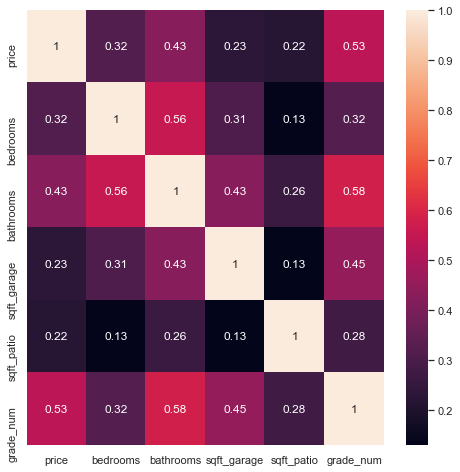

In [22]:
# Correlation heatmap to identify variable most correlated with price

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(df_model_iqr.corr(), annot=True);

We can see that 'grade_num' has the highest correlation to 'price', followed by 'bathrooms'.

In [23]:
# Creating simple model with the most correlated variable

X = df_model_iqr['grade_num']
y = df_model_iqr['price']

first_model = sm.OLS(y, sm.add_constant(X)).fit()
first_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 1.066e+04
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:05   Log-Likelihood:            -3.8413e+05
No. Observations:               27016   AIC:                         7.683e+05
Df Residuals:                   27014   BIC:                         7.683e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.966e+05   1.69e+04    -47.252      0.000    -8.3e+05   -7.64e+05
grade_num   2.305e+05   2232.607    103.262      0.000    2.26e+05    2.35e+05
==============================================================================
Omnibus:                     2216.346   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2872.605
Skew:                           0.727   Prob(JB):                         0.00
Kurtosis:                       3.662   Cond. No.                         58.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Calculate and return root-mean-square-error for first simple model (RMSE)

np.sqrt(first_model.mse_resid)

362063.03861651296

We added just grade to the model, which returned a high (but better than our baseline) mean error. We can also see that the grade of a home is responsible for about 28% of the variance in sale price.

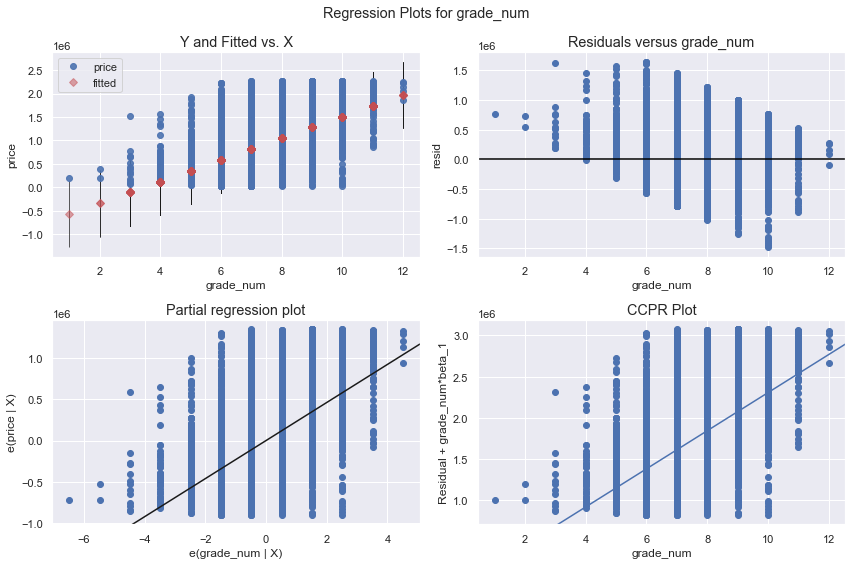

In [25]:
# Plot regression plots for numeric grade

fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(first_model, 'grade_num', fig=fig)
plt.show();

## Building Model With All Features

In [26]:
# Create training model with all variables

X = df_model_iqr.drop(columns=['price', 'grade'])
y = df_model_iqr['price']

price_model = sm.OLS(y, sm.add_constant(X)).fit()
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     2538.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:06   Log-Likelihood:            -3.8342e+05
No. Observations:               27016   AIC:                         7.668e+05
Df Residuals:                   27010   BIC:                         7.669e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -8.018e+05   1.85e+04    -43.296      0.000   -8.38e+05   -7.66e+05
bedrooms      5.35e+04   2719.683     19.673      0.000    4.82e+04    5.88e+04
bathrooms    6.513e+04   3871.745     16.823      0.000    5.75e+04    7.27e+04
sqft_garage  -101.5176      9.572    -10.605      0.000    -120.280     -82.755
sqft_patio    149.6338     13.402     11.165      0.000     123.365     175.903
grade_num    1.886e+05   2818.543     66.929      0.000    1.83e+05    1.94e+05
==============================================================================
Omnibus:                     2137.997   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2813.562
Skew:                           0.695   Prob(JB):                         0.00
Kurtosis:                       3.754   Cond. No.                     3.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
np.sqrt(price_model.mse_resid)

352712.5417315797

We added all features under the homeowner’s control to the model, which improved both our mean error and R-squared value. The model with all features also revealed the impact rankings of the features, with grade being most impactful and the presence of a garage least.

In [28]:
# Create standardized dataframe to get all variables on the same scale

X_standardized = df_model_iqr.drop(columns=['price', 'grade'])

for col in X_standardized:
    X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \
                            / X_standardized[col].std()
    
X_standardized.describe()

,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num
count,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04
mean,-1.454435e-16,6.706707e-17,8.416260e-17,2.038313e-17,-2.288171e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.502075e+00,-2.813545e+00,-1.179112e+00,-1.028531e+00,-6.574460e+00
25%,-3.616342e-01,-2.872224e-01,-1.179112e+00,-8.502278e-01,-4.933649e-01
50%,-3.616342e-01,3.443583e-01,2.079366e-01,-2.558848e-01,-4.933649e-01
75%,6.851793e-01,3.443583e-01,7.088153e-01,6.356298e-01,5.201509e-01
max,8.012874e+00,6.660165e+00,3.598500e+00,3.060550e+00,4.574214e+00


In [29]:
# Create standardized model

y = df_model_iqr['price']
X = X_standardized

price_model_std = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

price_model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     2538.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:06   Log-Likelihood:            -3.8342e+05
No. Observations:               27016   AIC:                         7.668e+05
Df Residuals:                   27010   BIC:                         7.669e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.294e+05   2145.904    433.099      0.000    9.25e+05    9.34e+05
bedrooms     5.111e+04   2598.059     19.673      0.000     4.6e+04    5.62e+04
bathrooms    5.156e+04   3065.123     16.823      0.000    4.56e+04    5.76e+04
sqft_garage -2.635e+04   2484.448    -10.605      0.000   -3.12e+04   -2.15e+04
sqft_patio   2.518e+04   2254.945     11.165      0.000    2.08e+04    2.96e+04
grade_num    1.861e+05   2780.956     66.929      0.000    1.81e+05    1.92e+05
==============================================================================
Omnibus:                     2137.997   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2813.562
Skew:                           0.695   Prob(JB):                         0.00
Kurtosis:                       3.754   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
np.sqrt(price_model_std.mse_resid), df_model_iqr['bathrooms'].std()

(352712.5417315797, 0.7916644560409257)

## Identifying Homeowner Renovation Impact on Price

In [31]:
# Dummy grade_num model

df_dummy_grade = df_model_iqr.copy()

df_dummy_grade['avg_grade'] = df_dummy_grade['grade_num'].mean()
X_grade = df_dummy_grade['avg_grade']
y_grade = df_dummy_grade['grade_num']
dummy_model_grade = sm.OLS(y_grade, sm.add_constant(X_grade)).fit()

dummy_model_grade.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grade_num   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Feb 2023   Prob (F-statistic):                nan
Time:                        22:41:06   Log-Likelihood:                -37971.
No. Observations:               27016   AIC:                         7.594e+04
Df Residuals:                   27015   BIC:                         7.595e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avg_grade      1.0000      0.001   1247.201      0.000       0.998       1.002
==============================================================================
Omnibus:                      631.092   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1108.406
Skew:                           0.198   Prob(JB):                    2.05e-241
Kurtosis:                       3.910   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
np.sqrt(dummy_model_grade.mse_resid)

0.9866644118277731

In [33]:
# Creating simple model with the most correlated variable

X = df_model_iqr['bathrooms']
y = df_model_iqr['grade_num']

first_grade_model = sm.OLS(y, sm.add_constant(X)).fit()
first_grade_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grade_num   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                 1.365e+04
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:06   Log-Likelihood:                -32446.
No. Observations:               27016   AIC:                         6.490e+04
Df Residuals:                   27014   BIC:                         6.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8784      0.015    402.360      0.000       5.850       5.907
bathrooms      0.7221      0.006    116.839      0.000       0.710       0.734
==============================================================================
Omnibus:                      714.838   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1384.144
Skew:                           0.191   Prob(JB):                    2.73e-301
Kurtosis:                       4.041   Cond. No.                         8.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
np.sqrt(first_grade_model.mse_resid)

0.8041923475007892

To determine the most effective way to increase the grade of a home, we performed a similar analysis with grade as the target. The baseline mean error was 0.99, which was decreased to 0.80 when adding just bathrooms to the model. The number of bathrooms explains about 34% of the variance in house grade.

In [35]:
# Grade model with all variables

X = df_model_iqr.drop(columns=['price', 'grade', 'grade_num'])
y = df_model_iqr['grade_num']

grade_model = sm.OLS(y, sm.add_constant(X)).fit()
grade_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grade_num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     4588.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:06   Log-Likelihood:                -30968.
No. Observations:               27016   AIC:                         6.195e+04
Df Residuals:                   27011   BIC:                         6.199e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.8959      0.018    334.104      0.000       5.861       5.930
bedrooms       -0.0267      0.006     -4.551      0.000      -0.038      -0.015
bathrooms       0.5629      0.008     73.833      0.000       0.548       0.578
sqft_garage     0.0010   1.98e-05     48.414      0.000       0.001       0.001
sqft_patio      0.0008   2.86e-05     26.862      0.000       0.001       0.001
==============================================================================
Omnibus:                      514.982   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.199
Skew:                           0.189   Prob(JB):                    4.78e-179
Kurtosis:                       3.765   Cond. No.                     1.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
np.sqrt(grade_model.mse_resid)

0.7614228229469278

After adding the remaining features to the model, we were able to decrease our mean error and increase our R-squared value. The impact rankings were slightly different, but number of bathrooms remained a critical feature in both sets of models.

In [37]:
# Standardize data so mean = 0 and standard deviation = 1

X_standardized = df_model_iqr.drop(columns=['price', 'grade'])

for col in X_standardized:
    X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \
                            / X_standardized[col].std()
    
X_standardized.describe()

,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num
count,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04,2.701600e+04
mean,-1.454435e-16,6.706707e-17,8.416260e-17,2.038313e-17,-2.288171e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.502075e+00,-2.813545e+00,-1.179112e+00,-1.028531e+00,-6.574460e+00
25%,-3.616342e-01,-2.872224e-01,-1.179112e+00,-8.502278e-01,-4.933649e-01
50%,-3.616342e-01,3.443583e-01,2.079366e-01,-2.558848e-01,-4.933649e-01
75%,6.851793e-01,3.443583e-01,7.088153e-01,6.356298e-01,5.201509e-01
max,8.012874e+00,6.660165e+00,3.598500e+00,3.060550e+00,4.574214e+00


In [38]:
# Create standardized model

y = df_model_iqr['grade_num']
X = X_standardized.drop(columns=['grade_num'])

grade_model_std = sm.OLS(endog=y, exog=sm.add_constant(X)).fit()

grade_model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              grade_num   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     4588.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:06   Log-Likelihood:                -30968.
No. Observations:               27016   AIC:                         6.195e+04
Df Residuals:                   27011   BIC:                         6.199e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4868      0.005   1616.144      0.000       7.478       7.496
bedrooms       -0.0255      0.006     -4.551      0.000      -0.037      -0.015
bathrooms       0.4456      0.006     73.833      0.000       0.434       0.457
sqft_garage     0.2491      0.005     48.414      0.000       0.239       0.259
sqft_patio      0.1291      0.005     26.862      0.000       0.120       0.138
==============================================================================
Omnibus:                      514.982   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.199
Skew:                           0.189   Prob(JB):                    4.78e-179
Kurtosis:                       3.765   Cond. No.                         2.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
np.sqrt(grade_model_std.mse_resid)

0.761422822946928

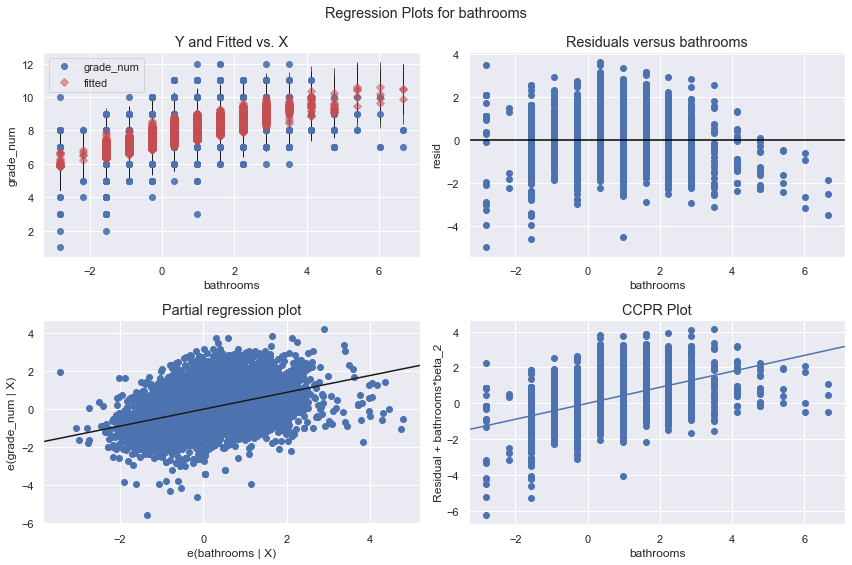

In [40]:
# Check regression plots

fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(grade_model_std, 'bathrooms', fig=fig)
plt.show()

In [41]:
df_model_iqr['sqft_garage'].std(), df_model_iqr['sqft_garage'].median()

(259.5438993747928, 360.0)

## Additional Analysis and Visualization

In [42]:
# Group data by grade to find mean values

bath_mean_grade = df_model_iqr.groupby('grade_num').mean()

In [43]:
bath_mean_grade

,price,bedrooms,bathrooms,sqft_garage,sqft_patio
grade_num,,,,,
1,2.050000e+05,1.000000,0.000000,0.000000,140.000000
2,3.025000e+05,0.500000,0.500000,0.000000,135.000000
3,4.644615e+05,1.461538,0.923077,57.692308,56.153846
4,5.597998e+05,1.446809,0.968085,6.382979,71.744681
5,5.743272e+05,2.059740,1.136364,26.758442,83.942857
6,6.113922e+05,2.701220,1.350072,76.463056,100.570660
7,8.008177e+05,3.303378,2.013626,264.924156,145.715672
8,1.020582e+06,3.493151,2.555365,366.605365,199.028425
9,1.329616e+06,3.739919,2.841230,456.977151,257.715726


In [44]:
bath_mean_grade.reset_index(drop=False, inplace=True)

In [45]:
df_model_iqr['grade_num'].value_counts()

7     11339
8      8760
9      2976
6      2788
10      619
5       385
11       81
4        47
3        13
12        5
2         2
1         1
Name: grade_num, dtype: int64

In [46]:
# Percentage of values with grades between 6 and 9

(11339 + 8760 + 2976 + 2788) / len(df_model_iqr['grade_num'])

0.9573215872075806

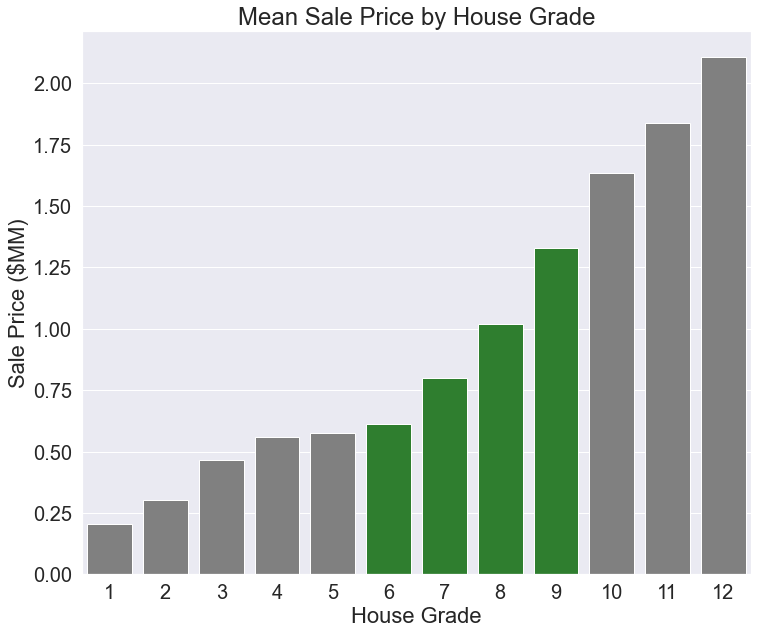

In [69]:
# Plotting average sale prices by house grade

fig, ax = plt.subplots(figsize = (12 , 10))

y = bath_mean_grade['price'] / 1000000
cols = ['gray','gray','gray','gray','gray','forestgreen','forestgreen','forestgreen','forestgreen','gray','gray','gray']

fig = sns.barplot(data = bath_mean_grade,
                  x = 'grade_num',
                  y = y,
                  palette=cols)

plt.xlabel('House Grade', size=22)
plt.xticks(size=20)
plt.ylabel('Sale Price ($MM)', size=22)
plt.yticks(fontsize=20)
plt.title('Mean Sale Price by House Grade', size=24)
plt.savefig("Models/Mean_Sale_Price_by_House_Grade.jpeg", bbox_inches = 'tight')
plt.show(fig);

In [48]:
# Repeating steps, this time with bathrooms

bath_mean = df_model_iqr.groupby('bathrooms').mean()

In [49]:
bath_mean.reset_index(drop=False, inplace=True)

In [50]:
bins = [0, .6, 1.6, 2.6, 3.6, 4.6, 5.6, 6.6, 7.6]
labels = ['0-.0.5', '1-1.5', '2-2.5', '3-3.5', '4-4.5', '5-5.5', '6-6.5', '7-7.5']
bath_mean['bin'] = pd.cut(x = bath_mean['bathrooms'], bins = bins, labels = labels, include_lowest = True)

bath_mean_bin = bath_mean.groupby('bin').mean()

bath_mean_bin

,bathrooms,price,bedrooms,sqft_garage,sqft_patio,grade_num
bin,,,,,,
0-.0.5,0.25,8.513598e+05,1.516667,194.000000,150.133333,6.150000
1-1.5,1.25,7.121465e+05,2.761165,159.911002,109.623647,6.760511
2-2.5,2.25,9.180776e+05,3.315150,329.511661,179.208661,7.591953
3-3.5,3.25,1.198395e+06,4.012747,413.005094,229.299072,8.148691
4-4.5,4.25,1.463401e+06,4.766375,467.993489,288.496100,8.640068
5-5.5,5.25,1.303222e+06,5.368056,566.543056,267.100000,8.812500
6-6.5,6.25,1.734875e+06,6.400000,343.666667,293.266667,8.433333
7-7.5,7.25,1.351917e+06,8.125000,304.583333,165.000000,7.958333


In [51]:
bath_mean_bin.reset_index(drop=False, inplace=True)

In [52]:
df_model_iqr['bathrooms'].value_counts()

2.5    7792
2.0    7040
1.0    4484
3.0    3591
1.5    1748
3.5    1620
4.0     423
4.5     187
5.0      45
0.0      30
5.5      24
6.0      15
6.5       5
0.5       5
7.0       4
7.5       3
Name: bathrooms, dtype: int64

In [53]:
(7792 + 7040 + 4484 + 3591 + 1748 + 1620) / len(df_model_iqr['bathrooms'])

0.9725718092981936

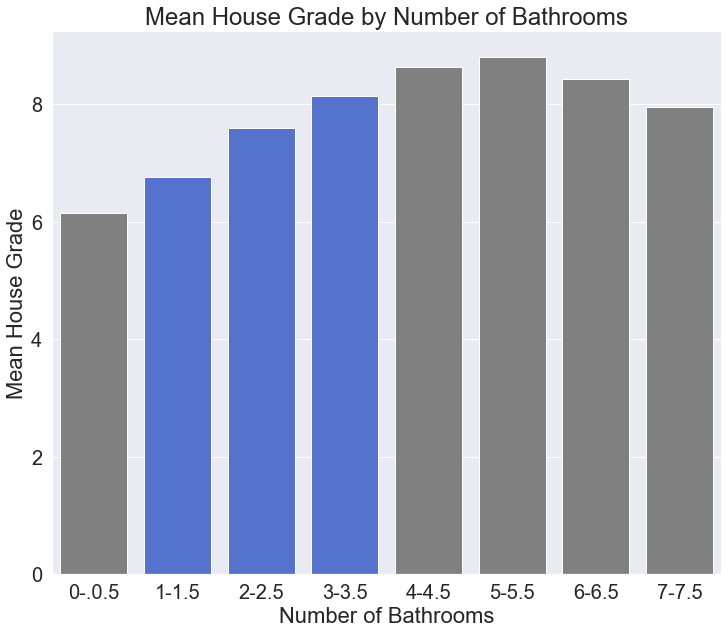

In [68]:
fig, ax = plt.subplots(figsize = (12 , 10))

y = bath_mean_bin['grade_num']
ticklabels = ['0-.0.5', '1-1.5', '2-2.5', '3-3.5', '4-4.5', '5-5.5', '6-6.5', '7-7.5']
cols = ['gray','royalblue','royalblue','royalblue','gray','gray','gray','gray']

fig = sns.barplot(data = bath_mean_bin,
                  x = 'bathrooms',
                  y = y,
                  palette=cols)

plt.xlabel('Number of Bathrooms', size=22)
ax.set_xticklabels(ticklabels, size=20)
plt.ylabel('Mean House Grade', size=22)
plt.yticks(fontsize=20)
plt.title('Mean House Grade by Number of Bathrooms', size=24)
plt.savefig("Models/Mean_House_Grade_by_Number_of_Bathrooms.jpeg", bbox_inches = 'tight')
plt.show(fig);

## Calculate Price Difference With Bathrooms

In [55]:
bath_dummies = pd.get_dummies(df_model_iqr['bathrooms'], prefix='bath')
df_model_iqr_bath = pd.concat([df_model_iqr, bath_dummies], axis=1)
df_model_iqr_bath

,price,bedrooms,bathrooms,grade,sqft_garage,sqft_patio,grade_num,bath_0.0,bath_0.5,bath_1.0,...,bath_3.0,bath_3.5,bath_4.0,bath_4.5,bath_5.0,bath_5.5,bath_6.0,bath_6.5,bath_7.0,bath_7.5
0,675000.0,4,1.0,7 Average,0,40,7,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,920000.0,5,2.5,7 Average,0,240,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,311000.0,6,2.0,7 Average,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,775000.0,3,3.0,9 Better,200,270,9,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,592500.0,2,2.0,7 Average,550,30,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,1555000.0,5,2.0,8 Good,0,210,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30151,1313000.0,3,2.0,7 Average,0,520,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30152,800000.0,3,2.0,7 Average,240,110,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30153,775000.0,3,2.5,8 Good,480,100,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Only the price and new bathroom columns
df_regr = df_model_iqr_bath[['price', 'bath_0.5','bath_1.5', 'bath_2.5', 'bath_3.5', 'bath_4.0', 'bath_5.5',]]
df_regr = sm.add_constant(df_regr)

# Fit the linear regression model
model = sm.OLS(df_regr['price'], df_regr.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     450.9
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:08   Log-Likelihood:            -3.8733e+05
No. Observations:               27016   AIC:                         7.747e+05
Df Residuals:                   27009   BIC:                         7.747e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.677e+05   3284.906    264.148      0.0

In [57]:
# Only the price and new bathroom columns
df_regr = df_model_iqr_bath[['price', 'bath_1.0', 'bath_1.5', 'bath_2.0', 'bath_2.5', 'bath_3.5', 'bath_4.0', 'bath_4.5', 'bath_5.0']]
df_regr = sm.add_constant(df_regr)

# Fit the linear regression model
model = sm.OLS(df_regr['price'], df_regr.drop('price', axis=1)).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     782.7
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:41:08   Log-Likelihood:            -3.8580e+05
No. Observations:               27016   AIC:                         7.716e+05
Df Residuals:                   27007   BIC:                         7.717e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.11e+06   6354.177    174.750      0.0

Each one-unit increase in homes with 1 bathrooms is associated with a decrease in price of approximately $439,000.

The coefficient for for homes with 2 and half bathrooms is a one-unit increase in bath_2.5 is associated with a decrease in price of approximately $121,000.

On the other hand, for homes with 3 and a half bathrooms is associated with an increase in price of approximately $177,000.

To renovate a home with 1 bathroom to a 1 and half bath increases price by $81,900. 

To renovate a home with 1 and half bath to 2 bath increases price by $93,800.

4 bath to 4.5 bath = 99,600

1 bath to 2 bath = 175,700

1.5 bath to 2.5 bath = 236,000

4 bath to 5 bath = 24,800


Approximate average increase in price when renovating in bathrooms:

Adding a full bath, 145,500 in value. 

Adding a half bath, approximately 91,770 in value.

In [58]:
# Reducing data to just price and bathrooms

df_price_bath = df_model_iqr[['price', 'bathrooms']]
df_price_bath

,price,bathrooms
0,675000.0,1.0
1,920000.0,2.5
2,311000.0,2.0
3,775000.0,3.0
4,592500.0,2.0
...,...,...
30150,1555000.0,2.0
30151,1313000.0,2.0
30152,800000.0,2.0
30153,775000.0,2.5


In [59]:
# Splitting data between 2 and 2.5 bathrooms

df_less_bathrooms = df_price_bath[df_price_bath['bathrooms'] <= 2]
df_more_bathrooms = df_price_bath[df_price_bath['bathrooms'] >= 2.5]

In [60]:
# Calculate mean price

avg_price_less_bathrooms = df_less_bathrooms['price'].mean()
avg_price_more_bathrooms = df_more_bathrooms['price'].mean()

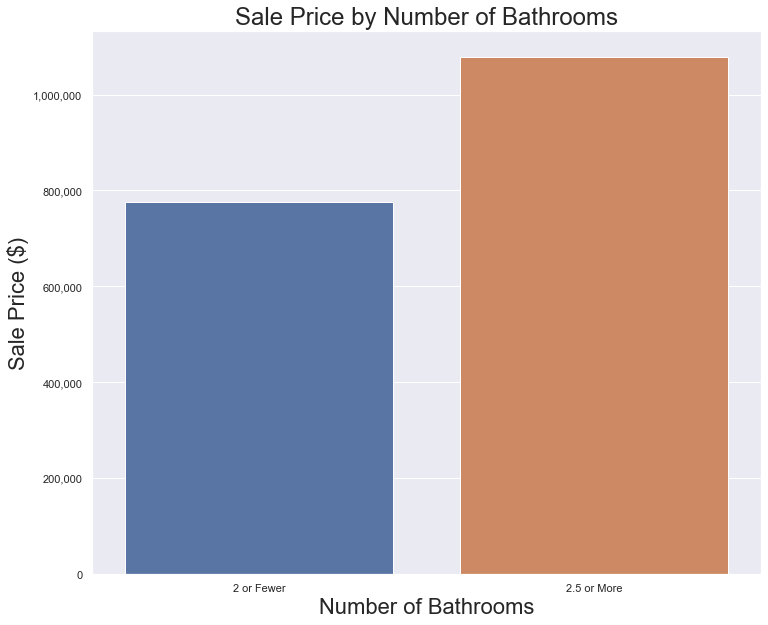

In [61]:
# Plotting mean sale price by number of bathrooms

import matplotlib.ticker as ticker

# format for commas in y-axis
def format_price(x, pos):
    return '{:,.0f}'.format(x)

fig, ax = plt.subplots(figsize = (12 , 10))

sns.barplot(x=['2 or Fewer', '2.5 or More'], y=[avg_price_less_bathrooms, avg_price_more_bathrooms])
plt.title('Sale Price by Number of Bathrooms', size=24)
plt.xlabel('Number of Bathrooms', size=22)
plt.ylabel('Sale Price ($)', size=22)
plt.ticklabel_format(style='plain', axis='y')

formatter = ticker.FuncFormatter(format_price)
plt.gca().yaxis.set_major_formatter(formatter)

plt.savefig("Models/Sale_Price_by_Number_of_Bathrooms.jpeg", bbox_inches = 'tight')

# Show the plot
plt.show()



In [62]:
df_price_bath['bathrooms'].value_counts()

2.5    7792
2.0    7040
1.0    4484
3.0    3591
1.5    1748
3.5    1620
4.0     423
4.5     187
5.0      45
0.0      30
5.5      24
6.0      15
6.5       5
0.5       5
7.0       4
7.5       3
Name: bathrooms, dtype: int64

In [63]:
price_2 = df_price_bath[df_price_bath['bathrooms'] == 2.0]['price'].mean()
price_2_5 = df_price_bath[df_price_bath['bathrooms'] == 2.5]['price'].mean()
price_diff = price_2_5 - price_2
print("Price difference between 2.0 and 2.5 bathrooms:", price_diff)

Price difference between 2.0 and 2.5 bathrooms: 142338.29658682563


In [64]:
mean_price_by_bath = df_model_iqr_bath.groupby('bathrooms')['price'].mean()
price_diff_by_bath = mean_price_by_bath.diff()
price_diff_dict = list(zip(df_model_iqr_bath.columns[7:], price_diff_by_bath.values))
price_diff_dict

[('bath_0.0', nan),
 ('bath_0.5', 252060.33333333337),
 ('bath_1.0', -306204.33519179304),
 ('bath_1.5', 81921.57260598068),
 ('bath_2.0', 93801.2333244487),
 ('bath_2.5', 142338.29658682563),
 ('bath_3.0', 120143.023819066),
 ('bath_3.5', 178009.55638633622),
 ('bath_4.0', 126234.04490412399),
 ('bath_4.5', 99535.25462383544),
 ('bath_5.0', -124397.84705882357),
 ('bath_5.5', -171098.5916666668),
 ('bath_6.0', 432087.8583333334),
 ('bath_6.5', 170229.93333333335),
 ('bath_7.0', -549490.0),
 ('bath_7.5', 162833.33333333326)]

In [65]:
for i in range(1, int(df_model_iqr_bath['bathrooms'].max())):
    if (i in df_model_iqr_bath['bathrooms'].values) and ((i+1) in df_model_iqr_bath['bathrooms'].values):
        price_i = df_model_iqr_bath[df_model_iqr_bath['bath_{}.0'.format(i)] == 1]['price'].mean()
        price_i_plus_1 = df_model_iqr_bath[df_model_iqr_bath['bath_{}.0'.format(i+1)] == 1]['price'].mean()
        price_diff = price_i_plus_1 - price_i
        print('Price difference between bath_{:.1f} and bath_{:.1f}: ${:,.2f}'.format(i, i+1, price_diff))

Price difference between bath_1.0 and bath_2.0: $175,722.81
Price difference between bath_2.0 and bath_3.0: $262,481.32
Price difference between bath_3.0 and bath_4.0: $304,243.60
Price difference between bath_4.0 and bath_5.0: $-24,862.59
Price difference between bath_5.0 and bath_6.0: $260,989.27
Price difference between bath_6.0 and bath_7.0: $-379,260.07


In [66]:
# Create new column for the price difference
df_model_iqr_bath['bath_2.5_minus_2.0'] = df_model_iqr_bath['bath_2.5'] - df_model_iqr_bath['bath_2.0']

# Compute the mean price for the rows where the difference is equal to 1
price_diff = df_model_iqr_bath[df_model_iqr_bath['bath_2.5_minus_2.0'] == 1]['price'].mean()

# Print the result
print("The average price difference between bath_2.0 and bath_2.5 is:", price_diff)

The average price difference between bath_2.0 and bath_2.5 is: 989246.767325462


In [67]:
df_model_iqr_bath.corr()

,price,bedrooms,bathrooms,sqft_garage,sqft_patio,grade_num,bath_0.0,bath_0.5,bath_1.0,bath_1.5,...,bath_3.5,bath_4.0,bath_4.5,bath_5.0,bath_5.5,bath_6.0,bath_6.5,bath_7.0,bath_7.5,bath_2.5_minus_2.0
price,1.000000,0.315523,0.428721,0.231807,0.220150,0.531990,-0.015912,0.001527,-0.269392,-0.108438,...,0.211474,0.142836,0.113987,0.043885,0.020104,0.039710,0.028339,0.009708,0.012421,-0.114332
bedrooms,0.315523,1.000000,0.557886,0.306644,0.133683,0.321011,-0.101643,-0.010617,-0.372642,-0.102049,...,0.166691,0.180053,0.129178,0.089752,0.060751,0.090171,0.034959,0.049739,0.062380,-0.120059
bathrooms,0.428721,0.557886,1.000000,0.426588,0.263552,0.579395,-0.093811,-0.029687,-0.691640,-0.241666,...,0.406012,0.282402,0.239669,0.143059,0.123268,0.112322,0.073430,0.073363,0.070189,-0.169885
sqft_garage,0.231807,0.306644,0.426588,1.000000,0.129720,0.454155,-0.025183,-0.001469,-0.340888,-0.095173,...,0.119289,0.053110,0.069041,0.042810,0.028609,-0.016410,0.013418,-0.002510,0.002056,-0.193031
sqft_patio,0.220150,0.133683,0.263552,0.129720,1.000000,0.279121,-0.019497,0.004249,-0.213934,-0.072180,...,0.095522,0.064853,0.071637,0.021885,0.017359,0.012255,0.012368,0.006650,-0.006768,0.006663
grade_num,0.531990,0.321011,0.579395,0.454155,0.279121,1.000000,-0.040105,-0.020502,-0.467440,-0.111618,...,0.247990,0.115767,0.118541,0.048847,0.044473,0.013853,0.018109,0.009413,0.001921,-0.139132
bath_0.0,-0.015912,-0.101643,-0.093811,-0.025183,-0.019497,-0.040105,1.000000,-0.000454,-0.014874,-0.008770,...,-0.008421,-0.004205,-0.002784,-0.001362,-0.000994,-0.000786,-0.000454,-0.000406,-0.000351,-0.019910
bath_0.5,0.001527,-0.010617,-0.029687,-0.001469,0.004249,-0.020502,-0.000454,1.000000,-0.006069,-0.003578,...,-0.003436,-0.001716,-0.001136,-0.000556,-0.000406,-0.000321,-0.000185,-0.000166,-0.000143,-0.008124
bath_1.0,-0.269392,-0.372642,-0.691640,-0.340888,-0.213934,-0.467440,-0.014874,-0.006069,1.000000,-0.117332,...,-0.112670,-0.056263,-0.037244,-0.018222,-0.013302,-0.010515,-0.006069,-0.005429,-0.004701,-0.266384
bath_1.5,-0.108438,-0.102049,-0.241666,-0.095173,-0.072180,-0.111618,-0.008770,-0.003578,-0.117332,1.000000,...,-0.066429,-0.033172,-0.021959,-0.010743,-0.007843,-0.006199,-0.003578,-0.003201,-0.002772,-0.157058


## Conclusion

We discovered that the grade of a home correlates strongly with its price. Specifically, homes with higher grades tend to have more desirable features, such as garages, patios, and a greater number of bedrooms and bathrooms. Therefore, to increase the grade of a home, it's necessary to perform renovations that add these desirable features.

Throughout our data, we found that different sizes of renovations will add different values. Homeowners who have invested more in their home renovation have been able to achieve a higher sale price for their home.

Based on our research, we recommend that homeowners consider upgrading specific features of their homes, whether it is for their own enjoyment or to attract more potential buyers. Specifically, adding or upgrading a bathroom was shown to have a high impact on both grade and price.

## Next Steps

Future research will help you find the highest return on investment in your local housing market. Seek advice from a professional home appraiser or real estate agent to get a better understanding of the potential impact of renovations on your home’s value. Lastly, plan renovations carefully to ensure they align with the overall goals of the home, such as increasing your enjoyment of the property or making your home market-ready.